# DATA2001 2021 Assignment
*An analysis of neighbourhood fire risk and median income & rent.*



In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np

import requests
import json

from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras

import matplotlib.pyplot as plt

In [2]:
# ------ Internal use MATTHEW
#For troubleshooting in the case your data isn't loading.
#os.chdir('M:\\Jupyter Notebooks\\data2001_project')
#os.getcwd()

## Task 1: Data Integration and Database Generation

### Loading datasets (standard dataframes)

In [3]:
stat_areas_df = pd.read_csv('./data/StatisticalAreas.csv')
print(stat_areas_df.dtypes)

area_id            int64
area_name         object
parent_area_id     int64
dtype: object


In [4]:
# Cleaning - remove duplicates
print(len(stat_areas_df.area_id.unique()))
print(stat_areas_df.area_id.value_counts())

# DUPLICATE ROWS in statisticalareas - confirmed

#stat_areas_df.loc[stat_areas_df['area_id']==106]
#stat_areas_df.loc[stat_areas_df['area_id']==111]
#stat_areas_df.loc[stat_areas_df['area_id']==114]

print(len(stat_areas_df))
stat_areas_df = stat_areas_df.drop_duplicates()
print(len(stat_areas_df))

stat_areas_df.head(2)

431
106          2
111          2
114          2
118011340    1
11903        1
            ..
125021477    1
125021476    1
116021562    1
114021289    1
124011450    1
Name: area_id, Length: 431, dtype: int64
434
431


,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1


In [5]:
nbhd_df = pd.read_csv('./data/Neighbourhoods.csv')

# nbhd_df.area_id.value_counts() # confirmed no duplicate area_id

# Changing column names according to assignment sheet
nbhd_df = nbhd_df.rename(columns={'number_of_dwellings':'dwellings', 'number_of_businesses':'businesses', 'median_annual_household_income':'median_income'}) 
nbhd_df.head(1)

,area_id,area_name,land_area,population,dwellings,businesses,median_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0


In [6]:
print(len(nbhd_df))
print(nbhd_df.dtypes)

322
area_id               int64
area_name            object
land_area           float64
population           object
dwellings            object
businesses          float64
median_income       float64
avg_monthly_rent    float64
dtype: object


In [7]:
# Cleaning - correcting number representation
nbhd_df['population'] = nbhd_df['population'].str.replace(',','')
nbhd_df['population'] = nbhd_df['population'].astype('float64')

nbhd_df['dwellings'] = nbhd_df['dwellings'].str.replace(',','')
nbhd_df['dwellings'] = nbhd_df['dwellings'].astype('float64')

In [8]:
busi_stat_df = pd.read_csv('./data/BusinessStats.csv')

busi_stat_df = busi_stat_df.drop(columns=['area_name']) #Not in the required columns according to May revision of assigment sheet v3
busi_stat_df = busi_stat_df.rename(columns={'accommodation_and_food_services':'accommodation_and_food'}) #Changing column names according to assignment sheet

# busi_stat_df.area_id.value_counts() # confirmed no duplicates
print(len(busi_stat_df))
print(busi_stat_df.dtypes)

2301
area_id                              int64
number_of_businesses                 int64
accommodation_and_food               int64
retail_trade                         int64
agriculture_forestry_and_fishing     int64
health_care_and_social_assistance    int64
public_administration_and_safety     int64
transport_postal_and_warehousing     int64
dtype: object


In [9]:
# DECISION: cast area_id in each df as string in order to ensure integrity going into DB as non-numeric values

stat_areas_df['area_id'] = stat_areas_df['area_id'].astype('str')
print(stat_areas_df['area_id'].dtype)

nbhd_df['area_id'] = nbhd_df['area_id'].astype('str')
print(nbhd_df['area_id'].dtype)

busi_stat_df['area_id'] = busi_stat_df['area_id'].astype('str')
print(busi_stat_df['area_id'].dtype)

object
object
object


In [10]:
# POSSIBLE DESIGN DECISION: LIMIT BUSINESS STAT OBSERVATIONS IN DB TO THE NEIGHBOURHOODS STUDIED

# print(len(busi_stat_df))
# busi_stat_df = busi_stat_df.loc[busi_stat_df['area_id'].isin(nbhd_df['area_id'].tolist())]
# print(len(busi_stat_df))

### Loading datasets (geodataframes)
#### RFS NSW Bushfire Prone Land - shapefile

In [11]:
rfs_gdf = gpd.read_file('./data/RFSNSW_BFPL/RFSNSW_BFPL.shp')
print(rfs_gdf.crs) # Check EPSG / CRS -- 4283 = GDA94
rfs_gdf.columns = [x.lower() for x in rfs_gdf.columns] # lower case col names
print(rfs_gdf.dtypes)
rfs_gdf.head(1)

epsg:4283
category         int64
shape_leng     float64
shape_area     float64
geometry      geometry
dtype: object


,category,shape_leng,shape_area,geometry
0,1,0.000017,5.392400e-12,POINT (149.11319 -33.05824)


In [12]:
# Check geometries
print(len(rfs_gdf))
rfs_gdf.geometry.type.value_counts()

516633


Point    516633
dtype: int64

In [13]:
# Recreate incrementing 'gid' (0 index)
rfs_gdf.insert(loc=0, column='gid', value=rfs_gdf.index)
rfs_gdf.head()

,gid,category,shape_leng,shape_area,geometry
0,0,1,0.000017,5.392400e-12,POINT (149.11319 -33.05824)
1,1,1,0.000178,1.140005e-09,POINT (152.27536 -29.68316)
2,2,1,0.000890,4.950178e-08,POINT (152.14244 -29.68266)
3,3,1,0.000442,8.094091e-09,POINT (152.27579 -29.68259)
4,4,1,0.000890,4.950155e-08,POINT (151.99619 -29.68131)


#### ABS Statistical Area 2 (2016) - shapefile

In [14]:
sa2_gdf = gpd.read_file('./data/1270055001_sa2_2016_aust_shape/SA2_2016_AUST.shp')

print(sa2_gdf.crs) # Check EPSG / CRS -- 4283 = GDA94

sa2_gdf.columns = [x.lower() for x in sa2_gdf.columns] # lower case col names

# Recreate incrementing 'g_id' (0 index)
sa2_gdf.insert(loc=0, column='g_id', value=sa2_gdf.index)

# Changing column names according to assignment sheet
sa2_gdf=sa2_gdf.rename(columns={'sa3_code16':'sa3_code', 'sa3_name16':'sa3_name', 'sa4_code16':'sa4_code', 'sa4_name16':'sa4_name', 'gcc_code16':'gcc_code', 'gcc_name16':'gcc_name', 'ste_code16':'ste_code', 'ste_name16':'ste_name'})

sa2_gdf['sa2_main16'] = sa2_gdf['sa2_main16'].astype('str')

sa2_gdf.head(1)

epsg:4283


,g_id,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geometry
0,0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."


In [15]:
# Check geometries
print(len(sa2_gdf))
print(sa2_gdf.geometry.type.value_counts())
no_geoms_sa2 = sum(sa2_gdf.geometry.type.isna())
print(f'Null geometry count: {no_geoms_sa2}')

2310
Polygon         2083
MultiPolygon     209
dtype: int64
Null geometry count: 18


In [16]:
sa2_gdf.loc[sa2_gdf.geometry.type.isna()].head(1)

,g_id,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geometry
576,576,197979799,19799,Migratory - Offshore - Shipping (NSW),19797,Migratory - Offshore - Shipping (NSW),197,Migratory - Offshore - Shipping (NSW),19799,Migratory - Offshore - Shipping (NSW),1,New South Wales,0.0,None


In [17]:
# Inspection / preliminary exploration
print(sa2_gdf.ste_name.value_counts()) # Confirm federal level dataset
print("\n")
print(sa2_gdf.loc[sa2_gdf.ste_name=="New South Wales"]['gcc_name'].value_counts()) # Confirm Greater Sydney GCCSA

New South Wales                 578
Queensland                      530
Victoria                        464
Western Australia               254
South Australia                 174
Australian Capital Territory    133
Tasmania                        101
Northern Territory               70
Other Territories                 6
Name: ste_name, dtype: int64


Greater Sydney                           312
Rest of NSW                              264
Migratory - Offshore - Shipping (NSW)      1
No usual address (NSW)                     1
Name: gcc_name, dtype: int64


In [18]:
# POSSIBLE DECISION: REMOVE THE 18 ROWS WHERE NO SPATIAL JOINS OR FUNCTIONS CAN BE PERFORMED (NULL GEOMETRIES)

#sa2_gdf = sa2_gdf[sa2_gdf['geometry'].notna()]
#print(sa2_gdf.loc[sa2_gdf.ste_name=="New South Wales"]['gcc_name'].value_counts())

### Additional dataset: Telephone Exchanges NSW
#### Geodataframe created from a retrieved JSON from ArcGIS REST Web Service provided by Geoscience Australia

EPSG:
{'wkid': 4283, 'latestWkid': 4283}


,name,geometry
574,Wooli,POINT (153.25366 -29.80452)
575,Wisemans Ferry,POINT (150.98660 -33.38578)
576,Werombi,POINT (150.57313 -33.97689)
577,Maraylya,POINT (150.91293 -33.59606)
578,Kemps Creek,POINT (150.82714 -33.87712)


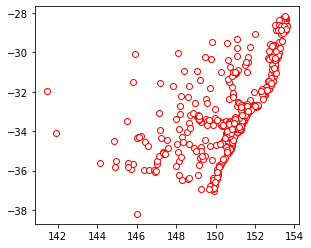

In [19]:
# Geoscience Australia - National Telephone Exchanges ArcGIS REST Web Service (Open API - no key required)
# https://services.ga.gov.au/gis/rest/services/Telephone_Exchanges/MapServer/0
# Usage permitted under Creative Commons Attribution 4.0 International Licence

# This service requires a relational model style syntax for its parameters, 
# e.g. WHERE (STATE)='New South Wales'
# These params then need to be converted to URL encoded characters for making the endpoint GET request

# We query the active communications exchanges in New South Wales to form our additional dataset
# with parameter: format = json

query_param = "%28STATE%29%3D%27New+South+Wales%27" # (STATE)='New South Wales'
response = requests.get("https://services.ga.gov.au/gis/rest/services/Telephone_Exchanges/MapServer/0/query?where="+
                        query_param+
                        "&f=json")

assert response.status_code == 200

exchanges_json = response.json()

# We have inspected the full JSON result in previous requests and deploy the keys accordingly

print('EPSG:\n' + str(exchanges_json['spatialReference'])) # Confirmed GDA94

# Convert results to pandas dataframe
names_recs = []
longs = []
lats = []

for i in range(0, len(exchanges_json['features'])):
    item_name = exchanges_json['features'][i]['attributes']['name']
    item_long = exchanges_json['features'][i]['geometry']['x']
    item_lat = exchanges_json['features'][i]['geometry']['y']
    names_recs.append(item_name)
    longs.append(item_long)
    lats.append(item_lat)

names_series = pd.Series(names_recs)
longs_series = pd.Series(longs)
lats_series = pd.Series(lats)

exchanges_df = pd.DataFrame({'name': names_series, 'longitude': longs_series,
                            'latitude': lats_series})

# Convert the df to geodataframe where longitude and latitude are combined into POINT geometries
exchanges_gdf = gpd.GeoDataFrame(exchanges_df,
                                       geometry=gpd.points_from_xy(exchanges_df.longitude, exchanges_df.latitude))

exchanges_gdf = exchanges_gdf.drop(columns=['longitude', 'latitude'])
exchanges_gdf.plot(color='white', edgecolor='red')
exchanges_gdf.tail()


### Connecting with Database and Creation of Tables

In [20]:
### ---------------ATTN MARKER 
# - RUN THIS---------------

# ASSUME THIS WORKS MOST GENERALLY E.g. FOR RUNNING IN USYD SERVER

# Function for accessing Postgres DB (SOURCE: DATA2001 Lab materials) - Eugene

def pgconnect_using_credfile(credential_filepath):
    try:
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        connstring = 'postgres+psycopg2://'+db_conn_dict['user']+':'+db_conn_dict['password']+'@'+db_conn_dict['host']+'/'+db_conn_dict['database']
        db = create_engine(connstring, echo=False)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return db,conn

print("function setup successful.")

function setup successful.


In [72]:
### ---------------ATTN MARKER - DO *NOT* RUN---------------
# Alternative Function for accessing Postgres DB (SOURCE: DATA2001 Lab materials) - Matthew
# JUST FOR MATTHEW

def pgconnect_using_credfile(credential_filepath):
    try:
        args = {
            'sslmode':'disable',
            'gssencmode':'disable'
        }
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        connstring = 'postgresql+psycopg2://'+db_conn_dict['user']+':'+db_conn_dict['password']+'@'+db_conn_dict['host']+'/'+db_conn_dict['database']
        db = create_engine(connstring, echo=False, connect_args=args)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return db,conn

In [75]:
# Connect to University server student Postgres DB

credfilepath = './data2x01_db.json' # Internal note: not tracked on Git, must be locally available. 
# Eugene's credentials JSON to be uploaded in submission

db, conn = pgconnect_using_credfile(credfilepath)

connected


In [73]:
# Function for querying the PostgreSQL DB.
# Returns value and a converted dataframe (SOURCE: DATA2001 Lab materials)

def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

print("function setup successful.")

function setup successful.


In [24]:
# Checking we have PostGIS working on our connection (SOURCE: DATA2001 Lab materials)

postgis_check = '''
SELECT PostGIS_Version();
'''

retval,retdf = pgquery(conn,postgis_check)
retdf

(1, 1)
                         postgis_version
0  3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Creation of Database Tables (from dataframes)

In [25]:
# Check existing tables in Postgres DB public schema
print(db.table_names())

['spatial_ref_sys', 'exchanges']


<ipython-input-25-36d40393d6b7>:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(db.table_names())


In [26]:
# Establishing set relationships between tables
test_df = stat_areas_df.copy() # 431 unique area_ids exist in statisticalareas
subset = set(nbhd_df.area_id.unique()) # 322 unique area_ids exist in neighbourhoods
test_df['exists'] = stat_areas_df.area_id.map(lambda x : True if x in subset else False)
test_df['exists'].value_counts()

# Statisticalareas contains a set of area_ids of which the set of neighbourhoods area_id values is a subset 
# (It is a PK in its own table and an FK in relation to statisticalareas)

True     322
False    109
Name: exists, dtype: int64

In [27]:
sa2s_in_statareas = stat_areas_df.loc[stat_areas_df['area_id'].str.len() == 9]
print(len(sa2s_in_statareas))

test_df2 = sa2_gdf.copy()
subset2 = set(sa2s_in_statareas.area_id.unique())
test_df2['exists'] = sa2_gdf.sa2_main16.map(lambda x : True if x in subset2 else False)
test_df2['exists'].value_counts()

323


False    1987
True      323
Name: exists, dtype: int64

#### Statistical Areas

In [28]:
conn.execute("DROP TABLE IF EXISTS statisticalareas")

stat_areas_create = '''CREATE TABLE statisticalareas (
                     area_id VARCHAR NOT NULL,
                     area_name VARCHAR NOT NULL,
                     parent_area_id VARCHAR NOT NULL,
                     CONSTRAINT statisticalareas_pkey PRIMARY KEY (area_id)
                     )'''

conn.execute(stat_areas_create)

In [29]:
# Insert dataset
stat_areas_df.to_sql('statisticalareas', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM statisticalareas
LIMIT 1;""")
a_df.head()

Data inserted into Table
(1, 3)
  area_id        area_name parent_area_id
0       1  New South Wales              0


,area_id,area_name,parent_area_id
0,1,New South Wales,0


#### Neighbourhoods

In [30]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods")

neighbourhoods_create = '''CREATE TABLE neighbourhoods (
                     area_id VARCHAR NOT NULL,
                     area_name VARCHAR NOT NULL,
                     land_area FLOAT NOT NULL,
                     population NUMERIC,
                     dwellings NUMERIC NOT NULL,
                     businesses NUMERIC,
                     median_income NUMERIC,
                     avg_monthly_rent NUMERIC,
                     CONSTRAINT neighbourhoods_pkey PRIMARY KEY (area_id),
                     CONSTRAINT neighbourhoods_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

# ALLOW NULL for 'population' 'businesses' avg_monthly_rent' 'median_income'
# CONSIDER PREPROCESS CLEANING LATER

conn.execute(neighbourhoods_create)

In [31]:
# Insert dataset
nbhd_df.to_sql('neighbourhoods', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM neighbourhoods
LIMIT 1;""")
a_df.head()

Data inserted into Table
(1, 8)
     area_id                 area_name  land_area  population  dwellings  businesses  median_income  avg_monthly_rent
0  102011028  Avoca Beach - Copacabana      643.8      7590.0     2325.0       738.0        46996.0            1906.0


,area_id,area_name,land_area,population,dwellings,businesses,median_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8,7590.0,2325.0,738.0,46996.0,1906.0


#### Business Stats

In [32]:
conn.execute("DROP TABLE IF EXISTS businessstats")

business_create = '''CREATE TABLE businessstats (
                     area_id VARCHAR NOT NULL,
                     number_of_businesses NUMERIC NOT NULL,
                     accommodation_and_food NUMERIC NOT NULL,
                     retail_trade NUMERIC NOT NULL,
                     agriculture_forestry_and_fishing NUMERIC NOT NULL,
                     health_care_and_social_assistance NUMERIC NOT NULL,
                     public_administration_and_safety NUMERIC NOT NULL,
                     transport_postal_and_warehousing NUMERIC NOT NULL,
                     CONSTRAINT businessstats_pkey PRIMARY KEY (area_id)
                     )'''

conn.execute(business_create)

In [33]:
busi_stat_df.to_sql('businessstats', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT COUNT(*) FROM businessstats
LIMIT 1;""")

Data inserted into Table
(1, 1)
   count
0   2301


In [76]:
a_response, a_df = pgquery(conn, """SELECT * FROM businessstats
LIMIT 1;""")
a_df.head()

(1, 8)
     area_id  number_of_businesses  accommodation_and_food  retail_trade  agriculture_forestry_and_fishing  health_care_and_social_assistance  public_administration_and_safety  transport_postal_and_warehousing
0  101021007                 629.0                    26.0          27.0                             280.0                               11.0                               0.0                              35.0


,area_id,number_of_businesses,accommodation_and_food,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,629.0,26.0,27.0,280.0,11.0,0.0,35.0


### Creation of Database Tables (from geodataframes)

#### RFS NSW Bushfire Prone Land - shapefile

In [35]:
# WKT point geom creation function (SOURCE: DATA2001 Lab materials)

def create_wkt_point_element(geom,srid):
    return WKTElement(geom.wkt, srid) #WKT stands for well-known text representation, i.e. its a markup language for representing vector geometry object

In [36]:
srid = 4283
rfs_gdf['geom'] = rfs_gdf['geometry'].apply(lambda x: create_wkt_point_element(geom=x, srid=srid))
rfs_gdf = rfs_gdf.drop(columns="geometry")
rfs_gdf.head()

,gid,category,shape_leng,shape_area,geom
0,0,1,0.000017,5.392400e-12,POINT (149.1131894786667 -33.05824346699998)
1,1,1,0.000178,1.140005e-09,POINT (152.2753625074807 -29.68315654934266)
2,2,1,0.000890,4.950178e-08,POINT (152.1424400005001 -29.68265650149996)
3,3,1,0.000442,8.094091e-09,POINT (152.2757861369404 -29.68259377308781)
4,4,1,0.000890,4.950155e-08,POINT (151.996189999 -29.68130649949998)


In [37]:
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")

rfs_bushfire_create = '''CREATE TABLE rfsnsw_bfpl (
                     gid INTEGER PRIMARY KEY,
                     category CHAR(1),
                     shape_leng FLOAT,
                     shape_area FLOAT,
                     geom GEOMETRY(POINT, 4283)
                     )'''

conn.execute(rfs_bushfire_create)

In [38]:
srid = 4283
rfs_gdf.to_sql('rfsnsw_bfpl', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('POINT', srid)})

In [39]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM rfsnsw_bfpl
LIMIT 1;""")
a_df.head()

(1, 5)
   gid category  shape_leng    shape_area                                                geom
0    0        1    0.000017  5.392400e-12  0101000020BB100000FEA38A3F9FA362403CFC9C85748740C0


,gid,category,shape_leng,shape_area,geom
0,0,1,0.000017,5.392400e-12,0101000020BB100000FEA38A3F9FA362403CFC9C857487...


#### ABS Statistical Area 2 (2016) - shapefile

In [40]:
# FILL NONE GEOMETRIES WITH EMPTY GEOMETRY OBJECTS SO THAT THEY CAN BE PERSISTED
# See: https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.fillna.html

sa2_gdf['geometry'] = sa2_gdf['geometry'].fillna()
print(len(sa2_gdf.loc[sa2_gdf.geometry.isna()]))
sa2_gdf.tail()

0


<ipython-input-40-aec642b6b250>:5: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  print(len(sa2_gdf.loc[sa2_gdf.geometry.isna()]))


,g_id,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geometry
2305,2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,GEOMETRYCOLLECTION EMPTY
2309,2309,999999499,99499,No usual address (OT),99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,0.0000,GEOMETRYCOLLECTION EMPTY


In [41]:
sa2_gdf.geometry.geom_type

0                  Polygon
1                  Polygon
2                  Polygon
3                  Polygon
4                  Polygon
               ...        
2305          MultiPolygon
2306          MultiPolygon
2307          MultiPolygon
2308    GeometryCollection
2309    GeometryCollection
Length: 2310, dtype: object

In [42]:
# WKT polygon geom creation function (SOURCE: DATA2001 Lab materials)

def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    elif (geom.geom_type == 'GeometryCollection'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [43]:
srid = 4283

# WKT CONVERSION
sa2_gdf['geom'] = sa2_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
sa2_gdf = sa2_gdf.drop(columns="geometry")
sa2_gdf.tail()

,g_id,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geom
2305,2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,MULTIPOLYGON (((96.83046599400006 -12.17635995...
2306,2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,MULTIPOLYGON (((150.6956629970001 -35.18296700...
2307,2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,MULTIPOLYGON (((167.9947210150001 -29.04533600...
2308,2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,MULTIPOLYGON EMPTY
2309,2309,999999499,99499,No usual address (OT),99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,0.0000,MULTIPOLYGON EMPTY


In [44]:
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")

sa2_shape_create = '''CREATE TABLE sa2_2016_aust (
                     g_id INTEGER PRIMARY KEY,
                     sa2_main16 VARCHAR,
                     sa2_5dig16 VARCHAR,
                     sa2_name16 VARCHAR,
                     sa3_code   VARCHAR,
                     sa3_name   VARCHAR,
                     sa4_code   VARCHAR,
                     sa4_name   VARCHAR,
                     gcc_code   VARCHAR,
                     gcc_name   VARCHAR,
                     ste_code   VARCHAR,
                     ste_name   VARCHAR,
                     areasqkm16 FLOAT,
                     geom GEOMETRY(MULTIPOLYGON, 4283)
                     )'''

conn.execute(sa2_shape_create)

In [45]:
srid = 4283
sa2_gdf.to_sql('sa2_2016_aust', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [46]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM sa2_2016_aust WHERE g_id = 2308""")

(1, 14)
   g_id sa2_main16 sa2_5dig16                            sa2_name16 sa3_code                              sa3_name sa4_code                              sa4_name gcc_code                              gcc_name ste_code           ste_name  areasqkm16                        geom
0  2308  997979799      99799  Migratory - Offshore - Shipping (OT)    99797  Migratory - Offshore - Shipping (OT)      997  Migratory - Offshore - Shipping (OT)    99799  Migratory - Offshore - Shipping (OT)        9  Other Territories         0.0  0106000020BB10000000000000


In [47]:
pgquery(conn, """SELECT COUNT(*) FROM sa2_2016_aust
LIMIT 1;""")

(1, 1)
   count
0   2310


(True,
    count
 0   2310)

### Creation of Database Table - Additional Dataset (geodataframe)

In [48]:
# Use create_wkt_point_element function to create point geom column

srid = 4283
exchanges_gdf['geom'] = exchanges_gdf['geometry'].apply(lambda x: create_wkt_point_element(geom=x, srid=srid))
exchanges_gdf = exchanges_gdf.drop(columns="geometry")
exchanges_gdf.head()

,name,geom
0,Dalley,POINT (151.208312988 -33.86289405799999)
1,City South,POINT (151.208221436 -33.87556075999998)
2,East,POINT (151.222091675 -33.87814521799999)
3,Glebe,POINT (151.188560486 -33.88067626999998)
4,Kent,POINT (151.204658508 -33.86639785800003)


In [49]:
conn.execute("DROP TABLE IF EXISTS exchanges")

exchanges_create = '''CREATE TABLE exchanges (
                     name VARCHAR NOT NULL,
                     geom GEOMETRY(POINT, 4283),
                     CONSTRAINT exchanges_pkey PRIMARY KEY (name) 
                     )'''

conn.execute(exchanges_create)

In [50]:
srid = 4283
exchanges_gdf.to_sql('exchanges', conn, if_exists='append', index=False,
                     dtype={'geom': Geometry('POINT', srid)})

In [71]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM exchanges WHERE name = 'Glebe' """)

db read error: 
(builtins.AttributeError) 'NoneType' object has no attribute 'cursor'
[SQL: SELECT * FROM exchanges WHERE name = 'Glebe' ]


In [74]:
# Disconnect from DB

conn.close()
db.dispose()
print("disconnected")


disconnected


## Task 2: Fire Risk Analysis



In [157]:
#Z-score
def z(x, avg, sd):
    return((x-avg)/sd)

#Sigmoidal function. Did not use native exponential because fails for large negative values.
def sigmoid(x):
    return(1/(1+np.exp(-x)))

#Fire risk score formula.
def fire_risk(pop_d, dwell_d, bus_d, bfpl_d, ass_serv_d, exchange_d):
    fire_risk_score = sigmoid(z(pop_d)+z(dwell_d)+z(bus_d)+z(bfpl_d)-z(ass_serv_d)-z(exchange_d))
    return fire_risk_score

def add_z_score_column(df, **kwargs):
    column = [c for c in df.columns.tolist() if 'density' in c][0] #Finds relevant column to calculate Z-score on
    if kwargs.get('column'):
        column = kwargs.get('column')
    mean = np.mean(df[column])
    std = np.std(df[column])
    df['z_score'] = df[column].map(lambda x: z(x, mean, std))
    return df
    

### Computed Measures

For the following computed densities we use SA2 area column as that is most accurately corresponds to area calculated based on geometry.


In [114]:
query='''
SELECT n.area_name, n.land_area, sa.areasqkm16, ST_Area(sa.geom::geography)/1000000 AS total_area_km2 
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
LIMIT 10;
'''
pgquery(conn, query)

(10, 4)
                     area_name   land_area  areasqkm16  total_area_km2
0        Gosford - Springfield   1691.2000     16.9124       16.911863
1              Goulburn Region   9035.1221   9035.1221     9035.121481
2     Avoca Beach - Copacabana    643.8000      6.4376        6.437286
3  Box Head - MacMasters Beach   3208.6000     32.0860       32.086453
4              Calga - Kulnura  76795.1000    767.9512      767.950792
5          Erina - Green Point   3379.3000     33.7934       33.793681
6                      Kariong    830.6000      8.3063        8.306383
7  Kincumber - Picketts Valley   1208.9000     12.0887       12.088774
8                       Narara    770.2000      7.7021        7.702222
9  Wamberal - Forresters Beach   1372.2000     13.7221       13.722908


(True,
                      area_name   land_area  areasqkm16  total_area_km2
 0        Gosford - Springfield   1691.2000     16.9124       16.911863
 1              Goulburn Region   9035.1221   9035.1221     9035.121481
 2     Avoca Beach - Copacabana    643.8000      6.4376        6.437286
 3  Box Head - MacMasters Beach   3208.6000     32.0860       32.086453
 4              Calga - Kulnura  76795.1000    767.9512      767.950792
 5          Erina - Green Point   3379.3000     33.7934       33.793681
 6                      Kariong    830.6000      8.3063        8.306383
 7  Kincumber - Picketts Valley   1208.9000     12.0887       12.088774
 8                       Narara    770.2000      7.7021        7.702222
 9  Wamberal - Forresters Beach   1372.2000     13.7221       13.722908)

#### 1. Population Density

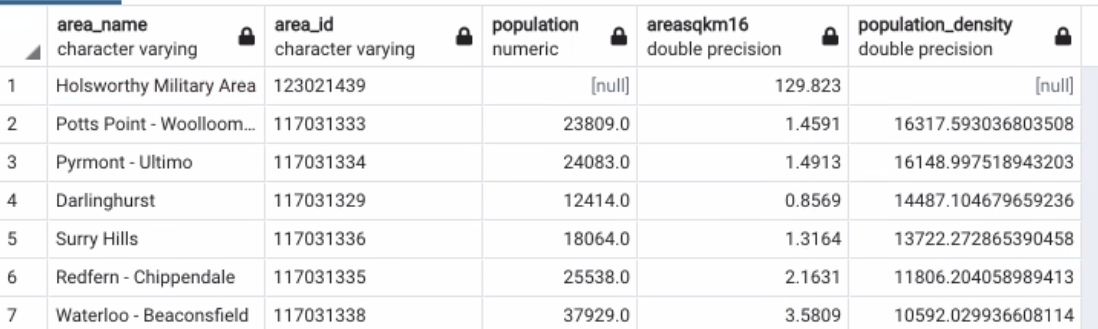

In [ ]:
query = '''
SELECT n.area_name, n.area_id, n.population, sa.areasqkm16, n.population/sa.areasqkm16 as population_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
ORDER BY n.population/sa.areasqkm16 DESC;
'''
response, pop_df = pgquery(conn, query)
pop_df =  add_z_score_column(pop_df)

(array([119.,  86.,  68.,  22.,  13.,   7.,   1.,   1.,   2.,   2.]),
 array([-1.08430611, -0.46291904,  0.15846802,  0.77985509,  1.40124216,
         2.02262922,  2.64401629,  3.26540335,  3.88679042,  4.50817749,
         5.12956455]),
 <BarContainer object of 10 artists>)

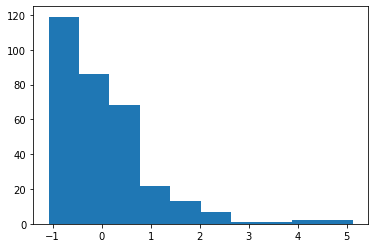

In [119]:
plt.hist(pop_df['z_score'])

#### 2. Dwelling Density

In [136]:
query = '''
SELECT n.area_name, n.area_id, n.dwellings, sa.areasqkm16, n.dwellings/sa.areasqkm16 as dwelling_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
ORDER BY n.dwellings/sa.areasqkm16 DESC;
'''

response, dwell_df = pgquery(conn, query)
dwell_df =  add_z_score_column(pop_df)

(322, 5)
                                       area_name    area_id  dwellings  areasqkm16  dwelling_density
0                    Potts Point - Woolloomooloo  117031333     8751.0      1.4591       5997.532726
1                               Pyrmont - Ultimo  117031334     7599.0      1.4913       5095.554214
2                                   Darlinghurst  117031329     3914.0      0.8569       4567.627494
3                                    Surry Hills  117031336     5040.0      1.3164       3828.623519
4                        Waterloo - Beaconsfield  117031338    12544.0      3.5809       3503.029965
5                          Redfern - Chippendale  117031335     7230.0      2.1631       3342.425223
6                       Neutral Bay - Kirribilli  121041416     7298.0      2.2106       3301.366145
7                               Randwick - North  118021569     5623.0      1.9356       2905.042364
8                      Bondi Beach - North Bondi  118011340     6486.0      2.4605

#### 3. Business Density

In [ ]:
query='''
SELECT n.area_name, n.area_id, sa.areasqkm16, busi.number_of_businesses, 
busi.number_of_businesses/sa.areasqkm16 as business_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
INNER JOIN businessstats AS busi
ON n.area_id=busi.area_id
ORDER BY busi.number_of_businesses/sa.areasqkm16 DESC;
'''
response, bus_df = pgquery(conn, query)
bus_df =  add_z_score_column(bus_df)

#### 4. BFPL Density

#### 5. Assistive Service Density

In [ ]:
query='''
SELECT n.area_name, n.area_id, sa.areasqkm16, busi.health_care_and_social_assistance,
busi.health_care_and_social_assistance/sa.areasqkm16 as assistive_service_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
INNER JOIN businessstats AS busi
ON n.area_id=busi.area_id
ORDER BY busi.health_care_and_social_assistance/sa.areasqkm16 DESC;
'''

response, ass_serv_df = pgquery(conn, query)
ass_serv_df =  add_z_score_column(ass_serv_df )

#### 6. Exchange Density

N.B. Getting a weird key error despite the column being correct. Unresolved.

In [ ]:
query='''
SELECT n.area_name, n.area_id, nsw_result.count AS exchanges, sa.areasqkm16,
nsw_result.count/sa.areasqkm16 AS exchange_density,
CASE
WHEN nsw_result.count IS NULL THEN 0
    ELSE nsw_result.count
END AS exchanges_inclzero,
CASE
    WHEN nsw_result.count/sa.areasqkm16 IS NULL THEN 0
    ELSE nsw_result.count/sa.areasqkm16
END AS exchange_density_inclzero
FROM neighbourhoods AS n
    INNER JOIN sa2_2016_aust AS sa
    ON n.area_id=sa.sa2_main16 
    LEFT JOIN
        (
            SELECT sa.sa2_main16, sa.sa2_name16, COUNT(e.geom)
            FROM sa2_2016_aust AS sa
                INNER JOIN exchanges AS e ON ST_Contains(sa.geom, e.geom)
            GROUP BY sa.sa2_main16, sa.sa2_name16
            ORDER BY COUNT(e.geom) DESC
        ) AS nsw_result
ON n.area_id = nsw_result.sa2_main16
ORDER BY nsw_result.count/sa.areasqkm16;

'''

response, exchange_df = pgquery(conn, query)
exchange_df =  add_z_score_column(exchange_df, column='exchange_density_inclzero')

#### Observing the distribution of the z-scores

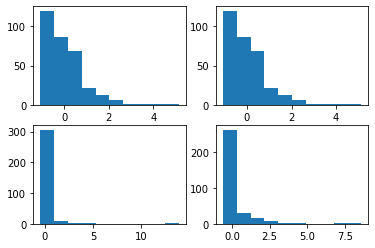

In [163]:
fig, axes = plt.subplots(2,2)
computed_measures = [pop_df, dwell_df, bus_df, ass_serv_df]

for type, ax in zip(computed_measures, axes.flatten()):
    ax.hist(type['z_score'])

### Fire Risk Score

$$fire_risk = S(z(population_density)+z(dwelling_&_business_density)+z(bfpl_density)−z(assistive_service_density))$$

### Linear Regression & Correlation

Pearson correlation coefficient calculated.
<div>
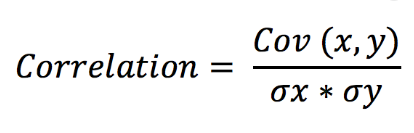
</div>

In [58]:
from sklearn.linear_model import LinearRegression

def LinearReg(y, X):
    query = """SELECT area_id, fire_risk_score, {X} FROM neighbourhoods INNER JOIN scores USING(area_id);""".format(x=x)
    response, df = pgquery(conn, query)
    y = df.loc[:, fire_risk_score]
    X = df.loc[:, X]
    reg = LinearRegression().fit(X,y)
    cor = df[['fire_risk_score', X]].corr()
    return reg, cor
    

In [ ]:

reg_model, cor = LinearReg('fire_risk_score', 'median_income')
